![Nuclio logo](https://nuclio.school/wp-content/uploads/2018/12/nucleoDS-newBlack.png)

# Connectar a Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Librerias

In [ ]:
from tensorflow import keras as ks
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import os

from tensorflow.keras.applications import vgg16
from tensorflow.keras.models import Model

# Variables de entorno

<font color="#FF0000">Aquí definireis vuestra ruta del proyecto de perros y Gatos</font>

In [ ]:
ANCHO_IMAGEN = 150
ALTURA_IMAGEN=150
IMAGE_SIZE = (ANCHO_IMAGEN, ALTURA_IMAGEN)
CANALES_IMAGENES = 3

ruta_archivos = '/content/drive/MyDrive/00_Nuclio_DS_Master/Dogs-vs-cats/'

# Cargaremos datos en NPZ


In [ ]:
dict_npz = np.load(ruta_archivos+'xy_train_img.npz')
x_train_img = dict_npz['x']
y_train_img = dict_npz['y']

dict_npz = np.load(ruta_archivos+'xy_test_img.npz')
x_test_img = dict_npz['x']
y_test_img = dict_npz['y']

dict_npz = np.load(ruta_archivos+'xy_val_img.npz')
x_val_img = dict_npz['x']
y_val_img = dict_npz['y']

In [ ]:
x_train_scaled = x_train_img / 255.
x_test_scaled = x_test_img / 255.
x_val_scaled = x_val_img / 255.

In [ ]:
y_train_img

array(['cat', 'cat', 'cat', ..., 'dog', 'dog', 'dog'], dtype='<U3')

# Montamos la Red Neuronal

## Cargar la parte de extraccion de features de VGG16

In [ ]:
# Creemos una red que será extracción de features basada en VGG16 entrenada con ImageNet

In [ ]:
vgg = vgg16.VGG16(include_top=False, weights="imagenet", input_shape=(150, 150,3))

In [ ]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [ ]:
output = vgg.layers[-1].output
new_output_layer = ks.layers.Flatten()(output)
vgg_model = Model(vgg.input, new_output_layer)

In [ ]:
vgg_model.summary() 

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [ ]:
# Veamos como va lo de "congelar" capas de entrenamiento - solo las que nos interesan

print(vgg_model.trainable)

True


In [ ]:
pd.set_option('max_colwidth', None)
layers = [(layer, layer.name, layer.trainable) for layer in vgg_model.layers]
pd.DataFrame(layers, columns=['Layer type', 'Name', 'Trainable?'])


,Layer type,Name,Trainable?
0,<keras.engine.input_layer.InputLayer object at 0x7f9cd75f5d50>,input_1,True
1,<keras.layers.convolutional.Conv2D object at 0x7f9cd3efa910>,block1_conv1,True
2,<keras.layers.convolutional.Conv2D object at 0x7f9d4eee0a10>,block1_conv2,True
3,<keras.layers.pooling.MaxPooling2D object at 0x7f9cc0abd190>,block1_pool,True
4,<keras.layers.convolutional.Conv2D object at 0x7f9cc0a6d390>,block2_conv1,True
5,<keras.layers.convolutional.Conv2D object at 0x7f9cc0a74950>,block2_conv2,True
6,<keras.layers.pooling.MaxPooling2D object at 0x7f9cc0a7c950>,block2_pool,True
7,<keras.layers.convolutional.Conv2D object at 0x7f9cc0a7e690>,block3_conv1,True
8,<keras.layers.convolutional.Conv2D object at 0x7f9ccf90d450>,block3_conv2,True
9,<keras.layers.convolutional.Conv2D object at 0x7f9cc0a823d0>,block3_conv3,True


In [ ]:
flag_trainable = False

for layer in vgg_model.layers:
  if layer.name == 'block4_conv1':
    flag_trainable = True
  layer.trainable = flag_trainable

In [ ]:
layers = [(layer, layer.name, layer.trainable) for layer in vgg_model.layers]
pd.DataFrame(layers, columns=['Layer type', 'Name', 'Trainable?'])

,Layer type,Name,Trainable?
0,<keras.engine.input_layer.InputLayer object at 0x7f9cd75f5d50>,input_1,False
1,<keras.layers.convolutional.Conv2D object at 0x7f9cd3efa910>,block1_conv1,False
2,<keras.layers.convolutional.Conv2D object at 0x7f9d4eee0a10>,block1_conv2,False
3,<keras.layers.pooling.MaxPooling2D object at 0x7f9cc0abd190>,block1_pool,False
4,<keras.layers.convolutional.Conv2D object at 0x7f9cc0a6d390>,block2_conv1,False
5,<keras.layers.convolutional.Conv2D object at 0x7f9cc0a74950>,block2_conv2,False
6,<keras.layers.pooling.MaxPooling2D object at 0x7f9cc0a7c950>,block2_pool,False
7,<keras.layers.convolutional.Conv2D object at 0x7f9cc0a7e690>,block3_conv1,False
8,<keras.layers.convolutional.Conv2D object at 0x7f9ccf90d450>,block3_conv2,False
9,<keras.layers.convolutional.Conv2D object at 0x7f9cc0a823d0>,block3_conv3,False


# Montamos la red vgg16 + mi capa de clasificación

*   Elemento de la lista
*   Elemento de la lista



In [ ]:
# Definamos el output de salida de la transformacion VGG16


print(vgg_model.output_shape)

output_from_vgg16 = vgg_model.output_shape[1]



(None, 8192)


In [ ]:
model_with_vgg = ks.Sequential()

# Apilaremos primero la VGG16
model_with_vgg.add(vgg_model)

model_with_vgg.add(ks.layers.Dense(512, activation='relu',input_shape=(output_from_vgg16, )))
model_with_vgg.add(ks.layers.Dropout(0.3))
model_with_vgg.add(ks.layers.Dense(512, activation='relu'))
model_with_vgg.add(ks.layers.Dropout(0.3))
model_with_vgg.add(ks.layers.Dense(1, activation='sigmoid'))

model_with_vgg.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 8192)              14714688  
                                                                 
 dense (Dense)               (None, 512)               4194816   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 513       
                                                                 
Total params: 19,172,673
Trainable params: 17,437,185
No

# Creamos un optimizador

In [ ]:
from tensorflow.keras.optimizers import Adam

In [ ]:
new_adam = Adam(learning_rate=2e-5) # 0.00002 

# > 4 millones de parametros -> bajad el LR 10-100 magnitudes... 0.0l -> 0.001 o 0.0001


In [ ]:
model_with_vgg.compile(loss='binary_crossentropy', optimizer=new_adam, metrics=['accuracy'])

# Early stopping!!

In [ ]:
callback_earlystopping = EarlyStopping(monitor='val_loss', patience=5)

# Model Checkpoint

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint


In [ ]:
callback_modelcheckpoint = ModelCheckpoint('/tmp/modelchk', monitor='val_accuracy', 
                                           verbose=1, save_best_only=True, 
                                           save_weights_only=True)

# Encoding de etiquetas

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(y_train_img)
y_train_encoded = le.transform(y_train_img)
y_val_encoded = le.transform(y_val_img)
y_test_encoded = le.transform(y_test_img)

In [ ]:
print(np.array(y_train_img))
print(np.array(y_train_encoded))

y_train_encoded

['cat' 'cat' 'cat' ... 'dog' 'dog' 'dog']
[0 0 0 ... 1 1 1]


array([0, 0, 0, ..., 1, 1, 1])

# Entrenar

In [ ]:
history = model_with_vgg.fit(x=x_train_scaled, y=y_train_encoded, batch_size=32,
                             epochs=10, callbacks=[callback_modelcheckpoint, callback_earlystopping], 
                             validation_data=(x_val_scaled, y_val_encoded))

Epoch 1/10
157/157 [==============================] - ETA: 0s - loss: 0.3587 - accuracy: 0.8312
Epoch 1: val_accuracy improved from -inf to 0.94200, saving model to /tmp/modelchk
157/157 [==============================] - 51s 292ms/step - loss: 0.3587 - accuracy: 0.8312 - val_loss: 0.1542 - val_accuracy: 0.9420
Epoch 2/10
157/157 [==============================] - ETA: 0s - loss: 0.1444 - accuracy: 0.9446
Epoch 2: val_accuracy did not improve from 0.94200
157/157 [==============================] - 44s 278ms/step - loss: 0.1444 - accuracy: 0.9446 - val_loss: 0.1399 - val_accuracy: 0.9420
Epoch 3/10
157/157 [==============================] - ETA: 0s - loss: 0.0766 - accuracy: 0.9710
Epoch 3: val_accuracy improved from 0.94200 to 0.95600, saving model to /tmp/modelchk
157/157 [==============================] - 44s 280ms/step - loss: 0.0766 - accuracy: 0.9710 - val_loss: 0.1165 - val_accuracy: 0.9560
Epoch 4/10
157/157 [==============================] - ETA: 0s - loss: 0.0354 - accuracy: 0

# Guardamos el modelo

Aquí tenemos que guardar el modelo simple, pero tambien hemos de guardar, o bien el modelo de preproceso o bien los datos de test procesados en NPZ...

In [ ]:
# Recuperamos los pesos del mejor modelo
model_with_vgg.load_weights('/tmp/modelchk')

# Modelo post VGG16
model_with_vgg.save(ruta_archivos+'model_with_fine_tuning_transfer_learning_with_vgg16.h5')



# Miremos que tal rinde el modelo en errores y accuracy

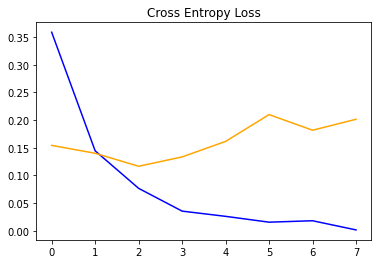

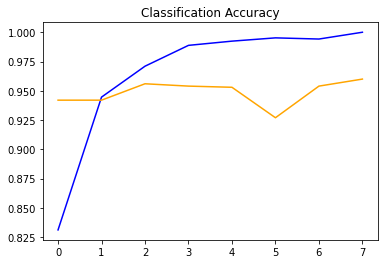

In [ ]:
plt.title('Cross Entropy Loss')
plt.plot(history.history['loss'], color='blue', label='train')
plt.plot(history.history['val_loss'], color='orange', label='val')
plt.show()

plt.title('Classification Accuracy')
plt.plot(history.history['accuracy'], color='blue', label='train')
plt.plot(history.history['val_accuracy'], color='orange', label='val')
plt.show()

In [ ]:
_, acc = model_with_vgg.evaluate(x_test_scaled, y_test_encoded, verbose=0)
print('Modelo con Fine Tunning Transfer Learning > %.3f' % (acc * 100.0))


Modelo con Fine Tunning Transfer Learning > 95.900
